# PRCP-1000 
### Portuguese Bank Marketing Project
#### Team Members: Prabhati Acharya, Sushree Sarangi, Vartika Vishnoi, and Vivek Viswanathan

This research focus on targeting through telemarketing phone calls to sell longterm deposits. Within a campaign, the human agents execute phone calls to a list of clients to sell the deposit (outbound) or, if meanwhile the client calls
the contact-center for any other reason, he is asked to subscribe the deposit (inbound). Thus, the result is a binary unsuccessful or successful contact.

This study considers real data collected from a Portuguese retail bank, in total of 41188 phone contacts. The dataset is unbalanced, as only 4640 (11.26%) records are related with successes. The test data is used for measuring the prediction capabilities of the selected data-driven model.

Each record included the output target, the contact outcome ({“failure”, “success”}), and candidate input features. These include telemarketing attributes (e.g., call direction), product details (e.g., interest rate offered) and client information (e.g., age). These records were enriched with social and economic influence features (e.g., unemployment variation rate), by gathering external data from the central bank of the Portuguese Republic statistical web site.

##### Import the necessary packages

In [1]:
# Import the necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
import itertools
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.feature_selection import RFECV
from vecstack import stacking
from mlxtend.classifier import StackingCVClassifier
from mlxtend.plotting import plot_learning_curves, plot_decision_regions
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.calibration import CalibratedClassifierCV
from pandas_profiling import ProfileReport
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO
import graphviz

import warnings
warnings.simplefilter('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
rand_state = 10
n_iterations = 5

In [3]:
# Load the data

#The complete dataset for all our analysis
Project_Data = pd.read_csv('../../Data/bank-additional-full.csv', sep=';')

# 10% dataset for SVM model execution.
Project_Data_svm = pd.read_csv('../../Data/bank-additional.csv', sep=';')

In [4]:
# Check sample SVM dataset 

Project_Data_svm.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [5]:
# Check sample of complete dataset

Project_Data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### EDA of the dataset

Perform the following exploratory data analysis on the dataset
- Shape of the dataset
- Info to get column names, number of not null count and data type
- Null Count
- Count of distinct values for each column
- The distinct values and the counts for the categorical variables


In [6]:
# Check the shape of the dataset

Project_Data.shape

(41188, 21)

In [7]:
Project_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [8]:
Project_Data_svm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [9]:
Project_Data.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [10]:
Project_Data_svm.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [11]:
Project_Data.nunique(dropna=False)

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [12]:
# Review the Categorical variables. 
### No transformation required for the categorical variables.
### We will identify candidates for one-hot encoding later in the process.

#print('\nUnique values of Project_Data.age:: \n',Project_Data.age.value_counts(dropna = False))
print('\nUnique values of Project_Data.job:: \n',Project_Data.job.value_counts(dropna = False))
print('\nUnique values of Project_Data.marital:: \n',Project_Data.marital.value_counts(dropna = False))
print('\nUnique values of Project_Data.education:: \n',Project_Data.education.value_counts(dropna = False))
print('\nUnique values of Project_Data.default:: \n',Project_Data.default.value_counts(dropna = False))
print('\nUnique values of Project_Data.housing:: \n',Project_Data.housing.value_counts(dropna = False))
print('\nUnique values of Project_Data.loan:: \n',Project_Data.loan.value_counts(dropna = False))
print('\nUnique values of Project_Data.contact:: \n',Project_Data.contact.value_counts(dropna = False))
#print('\nUnique values of Project_Data.day:: \n',Project_Data.day.value_counts(dropna = False))
print('\nUnique values of Project_Data.month:: \n',Project_Data.month.value_counts(dropna = False))
print('\nUnique values of Project_Data.day_of_week:: \n',Project_Data.day_of_week.value_counts(dropna = False))
#print('\nUnique values of Project_Data.campaign:: \n',Project_Data.campaign.value_counts(dropna = False))
#print('\nUnique values of Project_Data.previous:: \n',Project_Data.previous.value_counts(dropna = False))
print('\nUnique values of Project_Data.poutcome:: \n',Project_Data.poutcome.value_counts(dropna = False))
print('\nUnique values of Project_Data.emp.var.rate:: \n',Project_Data['emp.var.rate'].value_counts(dropna = False))
print('\nUnique values of Project_Data.cons.price.idx:: \n',Project_Data['cons.price.idx'].value_counts(dropna = False))
print('\nUnique values of Project_Data.cons.conf.idx:: \n',Project_Data['cons.conf.idx'].value_counts(dropna = False))
print('\nUnique values of Project_Data.euribor3m:: \n',Project_Data['euribor3m'].value_counts(dropna = False))
print('\nUnique values of Project_Data.nr.employed:: \n',Project_Data['nr.employed'].value_counts(dropna = False))
print('\nUnique values of Project_Data.y:: \n',Project_Data.y.value_counts(dropna = False))

#emp.var.rate        10
#cons.price.idx      26
#cons.conf.idx       26
#euribor3m          316
#nr.employed         11


Unique values of Project_Data.job:: 
 admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

Unique values of Project_Data.marital:: 
 married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

Unique values of Project_Data.education:: 
 university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

Unique values of Project_Data.default:: 
 no         32588
unknown     8597
yes            3
Name: default, dtype: int64

Unique values of Project_Data.housing:: 
 yes        21576
no         18622
unknown     

### Encoding the columns

Encode the following columns:
- y - Target variable
- job - Type of Job 
- marital - Marital Status
- education - Educational Classification
- default - Has credit in default?
- housing - Has housing loan? 
- loan - Has personal loan?
- contact - Contact communication type
- month - Last contact month of year
- day_of_week - Last contact day of the week 
- poutcome - Outcome of the previous marketing campaign

In [13]:
# Converted target variable from yes and no to 1 and 0

Project_Data.y = Project_Data.y.map(dict(yes=1, no=0))
Project_Data_svm.y = Project_Data_svm.y.map(dict(yes=1, no=0))

In [15]:
Project_Data_Encoded = Project_Data
Project_Data_svm_Encoded = Project_Data_svm

In [17]:
labelencoder = LabelEncoder()

In [18]:
objList = Project_Data_Encoded.select_dtypes(include = "object").columns
objList

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [19]:
for feat in objList:
    Project_Data_Encoded[feat] = labelencoder.fit_transform(Project_Data_Encoded[feat].astype(str))

In [20]:
objList_svm = Project_Data_svm_Encoded.select_dtypes(include = "object").columns
objList_svm

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [21]:
for feat in objList_svm:
    Project_Data_svm_Encoded[feat] = labelencoder.fit_transform(Project_Data_svm_Encoded[feat].astype(str))

In [22]:
Project_Data_Encoded

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,1,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,2,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,2,1,6,1,...,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5,1,5,0,2,0,0,7,0,...,1,999,0,1,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,1,1,5,0,0,0,0,7,0,...,1,999,0,1,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,5,1,6,0,2,0,0,7,0,...,2,999,0,1,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,9,1,5,0,0,0,0,7,0,...,1,999,0,1,-1.1,94.767,-50.8,1.028,4963.6,1


### Decision Tree Visualization



In [23]:
X_DT = Project_Data_Encoded.drop(columns=['y'], axis=1)
y_DT = Project_Data_Encoded.y

In [24]:
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size=0.25, random_state=10)

In [25]:
XGBoostError = ""
LightGBMError = ""
ValueError = ""
def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_train and y_train are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_train     (pandas DataFrame)
        
        y_train     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                        Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "plot_feature_importances"
    
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    #except (XGBoostError, LightGBMError, ValueError):
    except:
        clf.fit(X_train.values, y_train.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    plt.rcParams.update({'figure.autolayout': True})
    #plt.rcParams["axes.edgecolor"] = "0.15"
    #plt.rcParams["axes.linewidth"]  = 1.25
    #plt.grid()

    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(figsize=figsize)
    #plt.title("Feature Importances", fontsize = 15, fontweight="bold")
    plt.xlabel('Feature Importance Score', fontsize = 15)
    plt.ylabel('Features', fontsize = 15)
    plt.savefig('Feature_Importance_before_scaling_ohe.png')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp

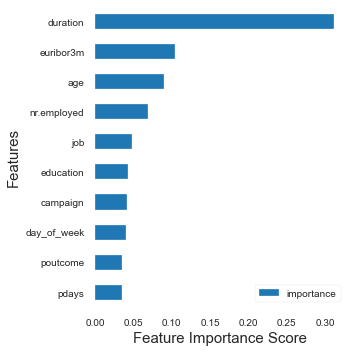

,importance
feature,
pdays,0.035117
poutcome,0.035263
day_of_week,0.040751
campaign,0.042288
education,0.043331
job,0.048269
nr.employed,0.068791
age,0.090699
euribor3m,0.104360


In [26]:
plot_feature_importances(RandomForestClassifier(random_state=rand_state), X_train_DT, y_train_DT, top_n=10, figsize=(5,5))

In [27]:
X_DT = Project_Data.drop(columns=['y'], axis=1)
y_DT = Project_Data.y

In [28]:
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size=0.25, random_state=10)

In [29]:
clf = DecisionTreeClassifier(max_depth=5)
clf = clf.fit(X_train_DT,y_train_DT)
y_pred = clf.predict(X_test_DT)

In [30]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_train_DT.columns,  
                                class_names=['no', 'yes'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph
graph.render("DT")

'DT.png'

# One Hot encoding for Categorical Variables

One Hot Encoding (ohe) is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction. The input to this transformer should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features.

#### Options used for pd.get_dummies
- data - Data of which to get dummy indicators 
    - Project_Data_drop_na
- prefix_sep - If appending prefix, separator/delimiter to use. Or pass a list or dictionary as with prefix.
    - "__"
- drop_first - Whether to get k-1 dummies out of k categorical levels by removing the first level
    - True
- columns - Column names in the DataFrame to be encoded.
    - cat_columns - List of Categorical features to passed through ohe

In [31]:
#Project_Data_ohe = pd.get_dummies(Project_Data, prefix_sep="__", drop_first=True, columns=cat_columns)

In [32]:
#Project_Data_ohe.info()

# Scaling the data set

It is a step of Data Pre Processing which is applied to independent variables or features of data. It basically helps to normalise the data within a particular range. Sometimes, it also helps in speeding up the calculations in an algorithm. The Features have been scaled to a mean of 0 and variance of 1 to improve accuracy of the classification models.

*fit_transform* within MinMaxScaler() function fits to data, then transform it. Fits transformer to X and y with optional parameters fit_params and returns a transformed version of X.

In [33]:
scaler = MinMaxScaler()

In [34]:
Project_Data_Encoded_scaled = pd.DataFrame(scaler.fit_transform(Project_Data_Encoded), columns=Project_Data_Encoded.columns)

In [35]:
Project_Data_svm_Encoded_scaled = pd.DataFrame(scaler.fit_transform(Project_Data_svm_Encoded), columns=Project_Data_svm_Encoded.columns)

In [36]:
Project_Data_Encoded_scaled.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,...,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.284248,0.338598,0.390923,0.535312,0.104436,0.535860,0.163713,0.365252,0.470096,0.501153,...,0.028502,0.963439,0.024709,0.465051,0.725393,0.535723,0.430854,0.677237,0.769134,0.112654
std,0.128657,0.326778,0.202967,0.305212,0.203343,0.492657,0.361808,0.481507,0.257781,0.349394,...,0.050364,0.187098,0.070700,0.181443,0.327283,0.225581,0.193648,0.393210,0.273163,0.316173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.185185,0.000000,0.333333,0.285714,0.000000,0.000000,0.000000,0.000000,0.333333,0.250000,...,0.000000,1.000000,0.000000,0.500000,0.333333,0.340608,0.338912,0.160961,0.512287,0.000000
50%,0.259259,0.181818,0.333333,0.428571,0.000000,1.000000,0.000000,0.000000,0.444444,0.500000,...,0.018182,1.000000,0.000000,0.500000,0.937500,0.603274,0.376569,0.957379,0.859735,0.000000
75%,0.370370,0.636364,0.666667,0.857143,0.000000,1.000000,0.000000,1.000000,0.666667,0.750000,...,0.036364,1.000000,0.000000,0.500000,1.000000,0.698753,0.602510,0.980957,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Correlation Matrix

We used correlation plot to identify the attributes in the original dataset that appeared to be highly collinear. In other words, one predictor variable in the regression model can be linearly predicted from the others with a substantial degree of accuracy.

corr = 1 were excluded to avoid displaying self correlated features.

In [37]:
corr = Project_Data_Encoded_scaled.corr()

kot = corr[(corr>=.8) & (corr<1)]
kot.dropna(axis=0, how='all', inplace = True)
kot.dropna(axis=1, how='all', inplace = True)
#plt.figure(figsize=(12,8))
#sns.heatmap(kot, annot=True, fmt='.4g', cmap= 'coolwarm', linewidths=3, linecolor='black')

matrix = np.triu(kot)
#sns.heatmap(kot, annot=True, fmt='.4g', cmap= 'coolwarm', mask = matrix)

### Highly Correlated variables

- Based on the above analysis, there aren't any highly correlated variables in the data set.
- We can now proceed with the models.

In [38]:
kot

,emp.var.rate,euribor3m,nr.employed
emp.var.rate,NaN,0.972245,0.906970
euribor3m,0.972245,NaN,0.945154
nr.employed,0.906970,0.945154,NaN


# SMOTE

In [39]:
X = Project_Data_Encoded_scaled.drop(columns=['y'], axis=1)
y = Project_Data_Encoded_scaled.y
smote = SMOTE()
X_smote, y_smote = smote.fit_sample(X.astype('float'), y)

In [40]:
sum(Project_Data_Encoded_scaled['y']==0)/sum(Project_Data_Encoded_scaled['y']==1)

7.876724137931035

In [155]:
sum(Project_Data_Encoded_scaled['y']==0)

36548

In [156]:
sum(Project_Data_Encoded_scaled['y']==1)

4640

In [41]:
X_svm = Project_Data_svm_Encoded_scaled.drop(columns=['y'], axis=1)
y_svm = Project_Data_svm_Encoded_scaled.y
smote = SMOTE()
X_svm_smote, y_svm_smote = smote.fit_sample(X_svm.astype('float'), y_svm)

In [42]:
sum(Project_Data_svm_Encoded_scaled['y']==0)/sum(Project_Data_svm_Encoded_scaled['y']==1)

8.133037694013304

In [43]:
sum(y_smote==0)/sum(y_smote==1)

1.0

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.25, random_state=rand_state)

In [45]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm_smote, y_svm_smote, test_size=0.25, random_state=rand_state)

In [46]:
sum(y_test==0)/sum(y_test==1)

1.004167580609783

In [47]:
sum(y_train==0)/sum(y_train==1)

0.9986146554866934

#### Set Baseline of the Cost Model

We start with executing selective models with default parameters on the complete data set. The confusion matrix along with the classification report and the accuracy of the model is printed below. The function confusion_mat displays the confusion matrix (using pd.crosstab) and classification report. It additionally extracts the FP and FN case counts and calculates the cost to the business partner.

### K-fold Cross-Validation

This is a statistical method of evaluating generalization performance that is more stable and thorough than using a split into a training and test set. In cross-validation, the data set is split multiple times and the model is trained on each of these splits. For our analysis, we will be using k-fold cross-validation. 

KFold divides all the samples in groups of samples, called folds (if , this is equivalent to the Leave One Out strategy), of equal sizes (if possible). The prediction function is learned using folds, and the fold left out is used for test.

Parameters for k-fold CV:
- n_splitsint - Number of folds
    - 5
- random_state - random_state is the seed used by the random number generator
    - 10

In [48]:
cv = KFold(n_splits=n_iterations, random_state=rand_state)

In [49]:
results_df = pd.DataFrame(columns=['Classifier', 'Features', 'Accuracy', 'Parameters', 'Recall', 
                                   'Precision', 'FPR', 'TPR', 'AUC', 'True_Positives', 
                                   'True_Negatives', 'False_Positives', 'False_Negatives', 'Cost'])
results_df

,Classifier,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives,Cost


In [50]:
def confusion_mat(y_test, y_pred):
    print('Confusion Matrix::\n')
    print(pd.crosstab(y_test, y_pred))
    print()
    print('Classification Report::')
    print(classification_report(y_test, y_pred))
    TN = pd.crosstab(y_test, y_pred).iloc[0, 0]
    FP = pd.crosstab(y_test, y_pred).iloc[0, 1]
    FN = pd.crosstab(y_test, y_pred).iloc[1, 0]
    TP = pd.crosstab(y_test, y_pred).iloc[1, 1]
    Cost = (FP*10)+(FN*500)
    Recall = recall_score(y_test, y_pred, average='weighted')
    Precision = precision_score(y_test, y_pred)
    Accuracy = accuracy_score(y_test, y_pred)
    return(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision)

In [51]:
clfsDict = {'Logistic Regression': LogisticRegression(solver = 'lbfgs', random_state=rand_state),
#            'SVM (SVC)': SVC(gamma = 0.5, random_state=rand_state, probability=True), 
            'Gaussian Naive-Bayes': GaussianNB(),
            'Bernoulli Naive-Bayes': BernoulliNB(),
            'Decision Tree': DecisionTreeClassifier(random_state=rand_state),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=rand_state),
            'XGB': XGBClassifier(random_state=rand_state)}

In [52]:
for mdl, clf in clfsDict.items():
    start_1 = time()
    acc = cross_val_score(clf,X,y=y,cv=cv)
    clf.fit(X_train, y_train)
    y_pred_full_data = clf.predict(X_test)
    y_pred_proba_full_data = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_full_data)
    auc = roc_auc_score(y_test, y_pred_proba_full_data)
    (FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_full_data)
    results_df = results_df.append({'Classifier':mdl
                                    , 'Features':'Full'
                                    , 'Parameters': 'Default'
                                    , 'Accuracy': Accuracy
                                    , 'Recall': Recall
                                    , 'Precision': Precision
                                    , 'FPR': fpr
                                    , 'TPR': tpr
                                    , 'AUC': auc
                                    , 'True_Positives': TP
                                    , 'True_Negatives': TN
                                    , 'False_Positives': FP
                                    , 'False_Negatives': FN
                                    , 'Cost': Cost
                                   }
                                   , ignore_index=True
                                  )
    print()
    print('Process Time:: %0f' %(time()-start_1))
    print()

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    7880  1276
1.0     944  8174

Classification Report::
              precision    recall  f1-score   support

         0.0       0.89      0.86      0.88      9156
         1.0       0.86      0.90      0.88      9118

    accuracy                           0.88     18274
   macro avg       0.88      0.88      0.88     18274
weighted avg       0.88      0.88      0.88     18274


Process Time:: 1.864383

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    7160  1996
1.0    2192  6926

Classification Report::
              precision    recall  f1-score   support

         0.0       0.77      0.78      0.77      9156
         1.0       0.78      0.76      0.77      9118

    accuracy                           0.77     18274
   macro avg       0.77      0.77      0.77     18274
weighted avg       0.77      0.77      0.77     18274


Process Time:: 0.373051

Confusion Matrix::

col_0   0.0   1.0
y                
0.0 

In [53]:
mdl = 'SVM (SVC)'
clf = SVC(gamma = 0.5, random_state=rand_state, probability=True)

clf.fit(X_train_svm, y_train_svm)
y_pred_full_data = clf.predict(X_test_svm)
y_pred_proba_full_data = clf.predict_proba(X_test_svm)[:, 1]
fpr, tpr, _ = roc_curve(y_test_svm,  y_pred_proba_full_data)
auc = roc_auc_score(y_test_svm, y_pred_proba_full_data)
(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test_svm, y_pred_full_data)
results_df = results_df.append({'Classifier':mdl
                                , 'Features':'Full'
                                , 'Parameters': 'Default'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0  0.0  1.0
y              
0.0    800  110
1.0     49  875

Classification Report::
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       910
         1.0       0.89      0.95      0.92       924

    accuracy                           0.91      1834
   macro avg       0.92      0.91      0.91      1834
weighted avg       0.92      0.91      0.91      1834



In [54]:
results_df

,Classifier,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives,Cost
0,Logistic Regression,Full,0.878516,Default,0.878516,0.864974,"[0.0, 0.0, 0.00021843599825251202, 0.000218435...","[0.0, 0.00010967317394165388, 0.00010967317394...",0.940097,8174,7880,1276,944,484760
1,Gaussian Naive-Bayes,Full,0.770822,Default,0.770822,0.776283,"[0.0, 0.013979903888160769, 0.0140891218872870...","[0.0, 0.20311471813994297, 0.20322439131388462...",0.852750,6926,7160,1996,2192,1115960
2,Bernoulli Naive-Bayes,Full,0.685947,Default,0.685947,0.693329,"[0.0, 0.00010921799912625601, 0.00021843599825...","[0.0, 0.0, 0.0, 0.0005483658697082694, 0.00065...",0.746340,6059,6476,2680,3059,1556300
3,Decision Tree,Full,0.922841,Default,0.922841,0.915212,"[0.0, 0.08595456531236348, 1.0]","[0.0, 0.9316736126343497, 1.0]",0.922860,8495,8369,787,623,319370
4,Random Forest,Full,0.950695,Default,0.950695,0.929984,"[0.0, 0.00010921799912625601, 0.00032765399737...","[0.0, 0.2025663522702347, 0.33494187321781094,...",0.992112,8886,8487,669,232,122690
5,XGB,Full,0.952774,Default,0.952774,0.950748,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00021934634788330776, 0.00065803904364...",0.993451,8706,8705,451,412,210510
6,SVM (SVC),Full,0.913304,Default,0.913304,0.888325,"[0.0, 0.0, 0.0, 0.001098901098901099, 0.001098...","[0.0, 0.0010822510822510823, 0.009740259740259...",0.953984,875,800,110,49,25600


# Feature Reduction (RFECV)

The classes in the sklearn.feature_selection module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets. We have used Recursive Feature Elimination with Cross-Validation to limit the number of features input to the model.

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

RFECV performs RFE in a cross-validation loop to find the optimal number of features.

Parameters for RFECV:
- estimator - A supervised learning estimator with a fit method that provides information about feature importance.
    - RandomForestClassifier
- step - If greater than or equal to 1, then step corresponds to the number of features to remove at each iteration.
    - 4
- cv - Determines the cross-validation splitting strategy. Integer value specifies the number of folds.
    - 3
- scoring - A scoring method to determine which score to maximize
    - recall

In [55]:
clf = RandomForestClassifier(n_estimators=100, random_state=rand_state)
selector = RFECV(estimator=clf, step = 4, cv=3, scoring='accuracy')

In [56]:
#%%time

feature_fit = selector.fit(X_train, y_train)

print('The number of selected features with CV:: ', feature_fit.n_features_)
print('Selected Features:: ', X_train.columns[selector.support_])

The number of selected features with CV::  20
Selected Features::  Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')


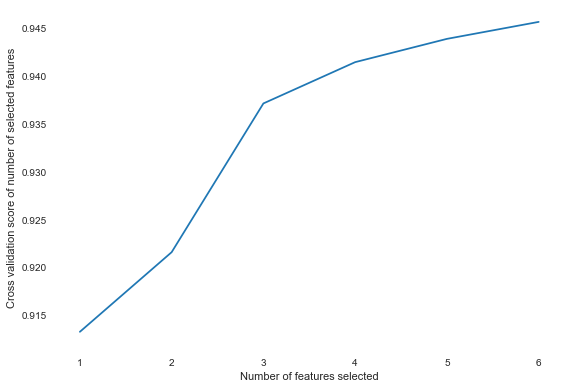

In [57]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [58]:
selector.grid_scores_

array([0.91326475, 0.92156434, 0.93706906, 0.9413739 , 0.94379993,
       0.9455693 ])

In [59]:
X_train_reduced_features = X_train[X_train.columns[selector.support_]]
X_test_reduced_features = X_test[X_test.columns[selector.support_]]

In [60]:
X_train_reduced_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54822 entries, 32719 to 50496
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             54822 non-null  float64
 1   job             54822 non-null  float64
 2   marital         54822 non-null  float64
 3   education       54822 non-null  float64
 4   default         54822 non-null  float64
 5   housing         54822 non-null  float64
 6   loan            54822 non-null  float64
 7   contact         54822 non-null  float64
 8   month           54822 non-null  float64
 9   day_of_week     54822 non-null  float64
 10  duration        54822 non-null  float64
 11  campaign        54822 non-null  float64
 12  pdays           54822 non-null  float64
 13  previous        54822 non-null  float64
 14  poutcome        54822 non-null  float64
 15  emp.var.rate    54822 non-null  float64
 16  cons.price.idx  54822 non-null  float64
 17  cons.conf.idx   54822 non-n

In [61]:
X_train_reduced_features.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
32719,0.148148,0.818182,0.666667,0.285714,0.0,1.0,0.0,0.0,0.666667,0.25,0.043514,0.000000,1.0,0.000000,0.5,0.333333,0.26968,0.192469,0.150759,0.512287
33686,0.333333,0.000000,0.333333,0.428571,0.0,1.0,0.0,0.0,0.666667,1.00,0.030500,0.036364,1.0,0.285714,0.0,0.333333,0.26968,0.192469,0.146679,0.512287


In [62]:
X_test_reduced_features.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
37038,0.197531,0.000000,0.333333,0.428571,0.0,0.0,0.0,1.0,0.333333,0.75,0.052257,0.000000,1.0,0.0,0.5,0.104167,0.104443,0.719665,0.092949,0.425709
10587,0.234568,0.909091,0.333333,0.428571,0.0,1.0,0.0,1.0,0.444444,0.75,0.132574,0.018182,1.0,0.0,0.5,1.000000,0.882307,0.376569,0.980957,1.000000


# Train the model on the reduced features

In this section all models use the default parameters to establish the baseline with reduced features before we tune the parameters using Randomized Search.

### Decision Tree

Decision trees can be applied to both regression and classification problems. While a regression tree is used to predict a quantitative response, a classification tree is used to predict a qualitative one. This algorithm constructs a tree from a training dataset in which each node is an attribute and branches are the corresponding values.

In [63]:
clf_DT_default = DecisionTreeClassifier(random_state=rand_state)
clf_DT_default.fit(X_train_reduced_features, y_train)
y_pred = clf_DT_default.predict(X_test_reduced_features)

y_pred_proba = clf_DT_default.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred)
results_df = results_df.append({'Classifier':'Decision Tree'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Default'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    8369   787
1.0     623  8495

Classification Report::
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92      9156
         1.0       0.92      0.93      0.92      9118

    accuracy                           0.92     18274
   macro avg       0.92      0.92      0.92     18274
weighted avg       0.92      0.92      0.92     18274



### Random Forest

Decision trees form the basis for Random Forests. Random Forest is an ensemble of decision trees trained via bagging method. The Random Forest algorithm introduces randomness when growing trees and rather than search for the best feature when splitting a node, it searches for the best feature among a random subset of features. It yeilds a better model by trading a higher bias for a lower variance. Random Forests are also very helpful to get a good understanding of feature importance when we need to perform feature selection.

In [64]:
clf_RF_default = RandomForestClassifier(random_state=rand_state)
clf_RF_default.fit(X_train_reduced_features, y_train)
y_pred = clf_RF_default.predict(X_test_reduced_features)

y_pred_proba = clf_RF_default.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred)
results_df = results_df.append({'Classifier':'Random Forest'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Default'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    8487   669
1.0     232  8886

Classification Report::
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      9156
         1.0       0.93      0.97      0.95      9118

    accuracy                           0.95     18274
   macro avg       0.95      0.95      0.95     18274
weighted avg       0.95      0.95      0.95     18274



### XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. 

In [65]:
clf_XGB_default = XGBClassifier(random_state=rand_state)
clf_XGB_default.fit(X_train_reduced_features, y_train)
y_pred = clf_XGB_default.predict(X_test_reduced_features)

y_pred_proba = clf_XGB_default.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred)
results_df = results_df.append({'Classifier':'XGB'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Default'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    8705   451
1.0     412  8706

Classification Report::
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      9156
         1.0       0.95      0.95      0.95      9118

    accuracy                           0.95     18274
   macro avg       0.95      0.95      0.95     18274
weighted avg       0.95      0.95      0.95     18274



In [66]:
results_df

,Classifier,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives,Cost
0,Logistic Regression,Full,0.878516,Default,0.878516,0.864974,"[0.0, 0.0, 0.00021843599825251202, 0.000218435...","[0.0, 0.00010967317394165388, 0.00010967317394...",0.940097,8174,7880,1276,944,484760
1,Gaussian Naive-Bayes,Full,0.770822,Default,0.770822,0.776283,"[0.0, 0.013979903888160769, 0.0140891218872870...","[0.0, 0.20311471813994297, 0.20322439131388462...",0.852750,6926,7160,1996,2192,1115960
2,Bernoulli Naive-Bayes,Full,0.685947,Default,0.685947,0.693329,"[0.0, 0.00010921799912625601, 0.00021843599825...","[0.0, 0.0, 0.0, 0.0005483658697082694, 0.00065...",0.746340,6059,6476,2680,3059,1556300
3,Decision Tree,Full,0.922841,Default,0.922841,0.915212,"[0.0, 0.08595456531236348, 1.0]","[0.0, 0.9316736126343497, 1.0]",0.922860,8495,8369,787,623,319370
4,Random Forest,Full,0.950695,Default,0.950695,0.929984,"[0.0, 0.00010921799912625601, 0.00032765399737...","[0.0, 0.2025663522702347, 0.33494187321781094,...",0.992112,8886,8487,669,232,122690
5,XGB,Full,0.952774,Default,0.952774,0.950748,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00021934634788330776, 0.00065803904364...",0.993451,8706,8705,451,412,210510
6,SVM (SVC),Full,0.913304,Default,0.913304,0.888325,"[0.0, 0.0, 0.0, 0.001098901098901099, 0.001098...","[0.0, 0.0010822510822510823, 0.009740259740259...",0.953984,875,800,110,49,25600
7,Decision Tree,Reduced,0.922841,Default,0.922841,0.915212,"[0.0, 0.08595456531236348, 1.0]","[0.0, 0.9316736126343497, 1.0]",0.922860,8495,8369,787,623,319370
8,Random Forest,Reduced,0.950695,Default,0.950695,0.929984,"[0.0, 0.00010921799912625601, 0.00032765399737...","[0.0, 0.2025663522702347, 0.33494187321781094,...",0.992112,8886,8487,669,232,122690
9,XGB,Reduced,0.952774,Default,0.952774,0.950748,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00021934634788330776, 0.00065803904364...",0.993451,8706,8705,451,412,210510


# RandomizedSearchCV to choose best parameters

In RandomizedSearchCV all hyperparameter values are not tried out. Instead, a fixed number of hyperparameter settings is sampled from specified probability distributions. You'll practice using RandomizedSearchCV in this exercise and see how this works.

#### Options for RandomizedSearchCV
- estimator - A object of that type is instantiated for each grid point.
    - Assigned as per the algorithm we are tuning
- param_distributions - Dictionary with parameters names (string) as keys and distributions or lists of parameters to try.
    - Assigned as per the algorithm we are tuning
- scoring - A single string to evaluate the predictions on the test set.
    - ['precision' , 'recall' , 'accuracy']
- cv - Determines the cross-validation splitting strategy.
    - 5
- refit - Refit an estimator using the best found parameters on the whole dataset.
    - recall
n_iterint - Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    - 10

In [67]:
scores = ['precision'
          , 'recall'
          , 'accuracy'
         ]

In [68]:
def report_perf(clf, n_top = 3, clf_name = "", verbose=True):
    if(verbose):
        for n in range(1, n_top+1):
            candidates = np.flatnonzero(clf.cv_results_['rank_test_recall'] == n)
            for candidate in candidates:
                print('Model with rank: {0}'.format(n))
                print('Mean validation score (Recall on Test): {0:.3f} (std: {1:.3f})'.format(
                    clf.cv_results_['mean_test_recall'][candidate], clf.cv_results_['std_test_recall'][candidate]))
                print('ParametersL {0}',format(clf.cv_results_['params'][candidate]))
    return{'Classifier': clf_name
           , 'Best_Parameters': str(clf.best_params_)
           , 'Best_Estimator': str(clf.best_estimator_)
#           , 'Accuracy_Mean':clf.cv_results_['mean_test_acc'][clf.best_index_]
#           , 'Accuracy_std':clf.cv_results_['std_test_acc'][clf.best_index_]
           , 'Precision_Mean':clf.cv_results_['mean_test_precision'][clf.best_index_]
           , 'Precision_std':clf.cv_results_['std_test_precision'][clf.best_index_]
           , 'Recall_Mean':clf.cv_results_['mean_test_recall'][clf.best_index_]
           , 'Recall_std':clf.cv_results_['std_test_recall'][clf.best_index_]
          }

# Decision Tree

We are tuning for the following parameters for *Decision Tree Classifier*:
- max_depth: The maximum depth of the tree.
    - [10, 20, 30, None]
- max_features: The number of features to consider when looking for the best split
    - ['auto', 'sqrt']
- criterion: The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain.
    - ['gini','entropy']
- min_samples_leaf: The minimum number of samples required to be at a leaf node.  
    - [1, 2, 4]
- min_samples_split: The minimum number of samples required to split an internal node
    - [2, 5, 10]
- random_state - If int, random_state is the seed used by the random number generator
    - 10

In [69]:
tuned_parameters_DT={'max_depth': [10, 20, 30, None]
                     , 'max_features': ['auto', 'sqrt']
                     , 'criterion':['gini','entropy']
                     , 'min_samples_leaf': [1, 2, 4]
                     , 'min_samples_split': [2, 5, 10]
                    }

clf_DT = DecisionTreeClassifier(random_state=rand_state)

In [70]:
#%%time

random_search_DT = RandomizedSearchCV(estimator=clf_DT
                                      , param_distributions=tuned_parameters_DT
                                      , cv = 5
                                      , scoring = scores
                                      , refit ='recall'
                                      , n_iter=10
                                     )

In [71]:
random_search_DT.fit(X_train_reduced_features, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=10,
            

In [72]:
DT_report = report_perf(random_search_DT, n_top = 3, clf_name='Decision_Tree')
DT_report

Model with rank: 1
Mean validation score (Recall on Test): 0.926 (std: 0.031)
ParametersL {0} {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}
Model with rank: 2
Mean validation score (Recall on Test): 0.921 (std: 0.003)
ParametersL {0} {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'criterion': 'entropy'}
Model with rank: 3
Mean validation score (Recall on Test): 0.908 (std: 0.028)
ParametersL {0} {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}


{'Classifier': 'Decision_Tree',
 'Best_Parameters': "{'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'entropy'}",
 'Best_Estimator': "DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',\n                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=2, min_samples_split=10,\n                       min_weight_fraction_leaf=0.0, presort='deprecated',\n                       random_state=10, splitter='best')",
 'Precision_Mean': 0.8716381754375133,
 'Precision_std': 0.009010830710903226,
 'Recall_Mean': 0.9257017863652935,
 'Recall_std': 0.03137935588048048}

# Random Forest

We are tuning the following parameters for Random Forest Classifier:
- n_estimators: The number of trees in the forest.
    - [100, 200]
- max_depth: The maximum depth of the tree.
    - [25, 50, None]
- criterion: The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain.
    - ['gini','entropy']
- min_samples_leaf: The minimum number of samples required to be at a leaf node.
    - [1, 25, 50]
- max_features: The number of features to consider when looking for the best split.
    - [.2, .3, 'auto']
- min_samples_split: The minimum number of samples required to split an internal node.
    - [2, 4, 8, 10, 12]

In [73]:
tuned_parameters_RF={'n_estimators':[100, 200]
                     , 'max_depth':[25, 50, None]
                     , 'criterion':['gini','entropy']
                     , 'min_samples_leaf': [1, 25, 50]
                     , 'max_features':[.2, .3, 'auto']
                     , 'min_samples_split':[2, 4, 8, 10, 12]
                    }

clf_RF = RandomForestClassifier(random_state=rand_state)

In [74]:
#%%time

random_search_RF = RandomizedSearchCV(estimator=clf_RF
                                      , param_distributions=tuned_parameters_RF
                                      , cv = 5
                                      , scoring = scores
                                      , refit = 'recall'
                                      , n_iter=10
                                     )

random_search_RF.fit(X_train_reduced_features, y_train)

RF_report = report_perf(random_search_RF, n_top = 3, clf_name='Random_Forest')

Model with rank: 1
Mean validation score (Recall on Test): 0.971 (std: 0.002)
ParametersL {0} {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'entropy'}
Model with rank: 2
Mean validation score (Recall on Test): 0.964 (std: 0.003)
ParametersL {0} {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 50, 'max_features': 'auto', 'max_depth': 25, 'criterion': 'entropy'}
Model with rank: 2
Mean validation score (Recall on Test): 0.964 (std: 0.003)
ParametersL {0} {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 50, 'max_features': 'auto', 'max_depth': 25, 'criterion': 'entropy'}


In [75]:
RF_report

{'Classifier': 'Random_Forest',
 'Best_Parameters': "{'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'entropy'}",
 'Best_Estimator': "RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,\n                       criterion='entropy', max_depth=50, max_features='auto',\n                       max_leaf_nodes=None, max_samples=None,\n                       min_impurity_decrease=0.0, min_impurity_split=None,\n                       min_samples_leaf=1, min_samples_split=8,\n                       min_weight_fraction_leaf=0.0, n_estimators=200,\n                       n_jobs=None, oob_score=False, random_state=10, verbose=0,\n                       warm_start=False)",
 'Precision_Mean': 0.9231789746166434,
 'Precision_std': 0.0028773737511005094,
 'Recall_Mean': 0.9707254830477579,
 'Recall_std': 0.002038302697556601}

# XGBoost

We are tuning the following parameters for XGBoost:
- n_estimators: Number of gradient boosted trees. Equivalent to number of boosting rounds.
    - [100, 150, 1000]
- learning_rate: Boosting learning rate (xgb’s “eta”)
    - [0.01, 0.6, None]
- subsample: Subsample ratio of the training instances.
    - [0.3, 0.9, None]
- max_depth: Maximum depth of a tree.
    - [3, 4, 5, 6, 7, 8, 9, None]
- colsample_bytree: The subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
    - [0.5, 0.9, None]
- min_child_weight: Minimum sum of instance weight (hessian) needed in a child.
    - [1, 2, 3, 4, None]

In [76]:
tuned_parameters_XGB={'n_estimators': [100, 150, 1000]
                      , 'learning_rate': [0.01, 0.6, None]
                      , 'subsample': [0.3, 0.9, None]
                      , 'max_depth': [3, 4, 5, 6, 7, 8, 9, None]
                      , 'colsample_bytree': [0.5, 0.9, None]
                      , 'min_child_weight': [1, 2, 3, 4, None]
                     }

clf_XGB = XGBClassifier(random_state=rand_state)

In [77]:
#%%time

random_search_XGB = RandomizedSearchCV(estimator=clf_XGB
                                      , param_distributions=tuned_parameters_XGB
                                      , cv = 5
                                      , scoring = scores
                                      , refit ='recall'
                                      , n_iter=10
                                     )

In [78]:
random_search_XGB.fit(X_train_reduced_features, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n...
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'colsample_bytree': [0.5, 0.9, None],
                                        '

In [79]:
XGB_report = report_perf(random_search_XGB, n_top = 3, clf_name='XGBoost')

Model with rank: 1
Mean validation score (Recall on Test): 0.953 (std: 0.002)
ParametersL {0} {'subsample': None, 'n_estimators': 150, 'min_child_weight': 2, 'max_depth': 9, 'learning_rate': None, 'colsample_bytree': 0.9}
Model with rank: 2
Mean validation score (Recall on Test): 0.953 (std: 0.002)
ParametersL {0} {'subsample': 0.3, 'n_estimators': 150, 'min_child_weight': 4, 'max_depth': None, 'learning_rate': 0.01, 'colsample_bytree': None}
Model with rank: 3
Mean validation score (Recall on Test): 0.952 (std: 0.002)
ParametersL {0} {'subsample': None, 'n_estimators': 150, 'min_child_weight': 4, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.9}


### Append random_state to the best parameters

We assign the best parameters from each of the Random Search to a variable and then add the random state parameter to it. These variables will be passed on to train the models with reduced features and best parameters.

In [80]:
DT_best_params = random_search_DT.best_params_
DT_best_params['random_state'] = rand_state

RF_best_params = random_search_RF.best_params_
RF_best_params['random_state'] = rand_state

XGB_best_params = random_search_XGB.best_params_
XGB_best_params['random_state'] = rand_state

### Train the model with the best parameters.

#### Decision Tree
- The best parameter (with random_state) from the previous step is chosen as classifier
- Confusion Matrix and Classification Reports are displayed 

In [81]:
clf_DT_best = DecisionTreeClassifier(**DT_best_params)
clf_DT_best.fit(X_train_reduced_features, y_train)

y_pred_DT = clf_DT_best.predict(X_test_reduced_features)

y_pred_proba = clf_DT_best.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_DT)
results_df = results_df.append({'Classifier':'Decision Tree'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    7840  1316
1.0     496  8622

Classification Report::
              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90      9156
         1.0       0.87      0.95      0.90      9118

    accuracy                           0.90     18274
   macro avg       0.90      0.90      0.90     18274
weighted avg       0.90      0.90      0.90     18274



#### Random Forest
- The best estimator from the previous step is chosen as classifier
- Confusion Matrix and Classification Reports are displayed

In [82]:
clf_RF_best = RandomForestClassifier(**RF_best_params)
clf_RF_best.fit(X_train_reduced_features, y_train)

y_pred_RF = clf_RF_best.predict(X_test_reduced_features)

y_pred_proba = clf_RF_best.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_RF)
results_df = results_df.append({'Classifier':'Random Forest'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    8456   700
1.0     243  8875

Classification Report::
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95      9156
         1.0       0.93      0.97      0.95      9118

    accuracy                           0.95     18274
   macro avg       0.95      0.95      0.95     18274
weighted avg       0.95      0.95      0.95     18274



#### XGBoost
- The best estimator from the previous step is chosen as classifier
- Confusion Matrix and Classification Reports are displayed 

In [83]:
clf_XGB_Best = XGBClassifier(**XGB_best_params)
clf_XGB_Best.fit(X_train_reduced_features, y_train)

y_pred_XGB = clf_XGB_Best.predict(X_test_reduced_features)

y_pred_proba = clf_XGB_Best.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_XGB)
results_df = results_df.append({'Classifier':'XGB'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    8704   452
1.0     423  8695

Classification Report::
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95      9156
         1.0       0.95      0.95      0.95      9118

    accuracy                           0.95     18274
   macro avg       0.95      0.95      0.95     18274
weighted avg       0.95      0.95      0.95     18274



# Ensemble Models

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Stacking, also called Super Learning or Stacked Regression, is a class of algorithms that involves training a second-level "metalearner" to find the optimal combination of the base learners. Unlike bagging and boosting, the goal in stacking is to ensemble strong, diverse sets of learners together.

### Ensemble Model 1

The first ensemble technique uses the vecstack package for stacking. It is compatible with the scikit-learn API to automate OOF computation, prediction and bagging using multiple models and stages.

Below, we use the Best Decision Tree and Random Forest classifiers in Stage 1. The Stage 1 output is passed on to Stage 2 which uses the XGBoost classifier with the best parameters. Finally, Logistic Regression is used as the Meta Classifier to predict the outcome and compare against the test dataset. 

In [110]:
models_1 = [clf_DT_best
            , clf_RF_best]

# Get out-of-fold predictions from 1-level models
S_1_train, S_1_test = stacking(models_1
                               , X_train_reduced_features
                               , y_train
                               , X_test_reduced_features
                               , regression = True
                               , metric=recall_score
                               , verbose = 2)

task:         [regression]
metric:       [recall_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [DecisionTreeClassifier]
    fold  0:  [0.90281813]
    fold  1:  [0.91186787]
    fold  2:  [0.86835106]
    fold  3:  [0.94319493]
    ----
    MEAN:     [0.90655800] + [0.02666559]
    FULL:     [0.90678090]

model  1:     [RandomForestClassifier]
    fold  0:  [0.97051133]
    fold  1:  [0.96959953]
    fold  2:  [0.97177896]
    fold  3:  [0.97087659]
    ----
    MEAN:     [0.97069160] + [0.00078129]
    FULL:     [0.97068903]



In [111]:
# Initialize 2-level models
models_2 = [clf_XGB_Best]

# Get out-of-fold predictions from 2-level models
S_2_train, S_2_test = stacking(models_2
                               , S_1_train
                               , y_train
                               , S_1_test
                               , regression = True
                               , metric=recall_score
                               , verbose = 2)

task:         [regression]
metric:       [recall_score]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [XGBClassifier]
    fold  0:  [0.97051133]
    fold  1:  [0.96959953]
    fold  2:  [0.97177896]
    fold  3:  [0.97087659]
    ----
    MEAN:     [0.97069160] + [0.00078129]
    FULL:     [0.97068903]



In [112]:
# Initialize 3-level model
model = LogisticRegression(random_state=rand_state)
# Fit
model.fit(S_2_train, y_train)
# Get final prediction
y_pred_ensemble = model.predict(S_2_test)

In [113]:
model.predict_proba(S_2_test)

array([[0.07742119, 0.92257881],
       [0.07742119, 0.92257881],
       [0.96881098, 0.03118902],
       ...,
       [0.96881098, 0.03118902],
       [0.96881098, 0.03118902],
       [0.96881098, 0.03118902]])

In [114]:
y_pred_proba = model.predict_proba(S_2_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_ensemble)
results_df = results_df.append({'Classifier':'Vecstack'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    8349   807
1.0     206  8912

Classification Report::
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      9156
         1.0       0.92      0.98      0.95      9118

    accuracy                           0.94     18274
   macro avg       0.95      0.94      0.94     18274
weighted avg       0.95      0.94      0.94     18274



### Ensemble Model 2

The second ensemble technique uses the StackingCVClassifier from mlxtend package. 

In this model, we pass all our 3 best models (Decision Tree, Random Forest and XGBoost) together in 1 stage. Similar to the previous ensemble model, we use Logistic Regression as our Meta-Classifier.

In [115]:
sclf = StackingCVClassifier(classifiers=[clf_DT_best, clf_RF_best, clf_XGB_Best]
                            , use_probas=True
                            , random_state= rand_state
                            , meta_classifier=LogisticRegression(random_state=rand_state))

In [116]:
label = ['Decision Tree', 'Random Forest', 'XGBoost', 'Stacking Classifier']
clf_list = [clf_DT_best, clf_RF_best, clf_XGB_Best, sclf]
    
sclf.fit(X_train_reduced_features, y_train)
y_pred_sclf = sclf.predict(X_test_reduced_features)

In [117]:
y_pred_proba = sclf.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_sclf)
results_df = results_df.append({'Classifier':'StackingCV'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    8677   479
1.0     342  8776

Classification Report::
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      9156
         1.0       0.95      0.96      0.96      9118

    accuracy                           0.96     18274
   macro avg       0.96      0.96      0.96     18274
weighted avg       0.96      0.96      0.96     18274



### Ensemble Model 3

Stack of estimators with a final classifier. Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

In this step, we use multi-layer classsifier technique. In multi-layer classifier, we assign the final estimator to a stacking classifier.

In [118]:
final_layer = StackingClassifier(estimators=[('rf', clf_RF_best)
                                            , ('xgb', clf_XGB_Best)]
                                , final_estimator=LogisticRegression(random_state=rand_state)
                               )

multi_layer_regressor = StackingClassifier(estimators=[('dt', clf_DT_best)]
                                          , final_estimator=final_layer
                                         )

multi_layer_regressor.fit(X_train_reduced_features, y_train)

y_pred_multi = multi_layer_regressor.predict(X_test_reduced_features)

In [119]:
y_pred_proba = multi_layer_regressor.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_multi)
results_df = results_df.append({'Classifier':'Stacking (Logistic)'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    7860  1296
1.0     690  8428

Classification Report::
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89      9156
         1.0       0.87      0.92      0.89      9118

    accuracy                           0.89     18274
   macro avg       0.89      0.89      0.89     18274
weighted avg       0.89      0.89      0.89     18274



### Ensemble Model 4

Ensemble Model 4 is similar to Ensemble Model 3. However, in this step, we use a single stacking layer with Decision Tree, Random Forest and XGBoost with the best parameters passed as ensemble estimators. SGD is chosen as the final estimator or meta-classifier as discussed in Ensemble Model 1 and 2.

In [120]:
ensemble_estimators = [('rf', clf_RF_best)
                       , ('xgb', clf_XGB_Best)
                       , ('dt', clf_DT_best)
#                       , ('logistic', LogisticRegression(random_state=rand_state))
                      ]

clf_ensemble = StackingClassifier(estimators=ensemble_estimators
                                  , final_estimator=CalibratedClassifierCV(SGDClassifier(random_state=rand_state))
#                                  , final_estimator=SVC(gamma = 0.5, random_state=rand_state)
                                 )

clf_ensemble.fit(X_train_reduced_features, y_train)

StackingClassifier(cv=None,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='entropy',
                                                       max_depth=50,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=8,
                                    

In [121]:
y_pred_ens = clf_ensemble.predict(X_test_reduced_features)

In [122]:
y_pred_proba = clf_ensemble.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_ens)
results_df = results_df.append({'Classifier':'Stacking (SGD)'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    8705   451
1.0     386  8732

Classification Report::
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95      9156
         1.0       0.95      0.96      0.95      9118

    accuracy                           0.95     18274
   macro avg       0.95      0.95      0.95     18274
weighted avg       0.95      0.95      0.95     18274



# Ensemble Model 5

Ensemble model 5 is the same as Ensemble Model 4. The only difference is that we are using SMV (SVC) as the final estimator here instead of SGD.

In [123]:
ensemble_estimators_5 = [('rf', clf_RF_best)
                       , ('xgb', clf_XGB_Best)
                       , ('dt', clf_DT_best)
#                       , ('logistic', LogisticRegression(random_state=rand_state))
                      ]

clf_ensemble_5 = StackingClassifier(estimators=ensemble_estimators_5
#                                   , final_estimator=SGDClassifier(random_state=rand_state)
                                    , final_estimator=CalibratedClassifierCV(SVC(gamma = 0.5, random_state=rand_state))
                                 )

clf_ensemble_5.fit(X_train_reduced_features, y_train)

StackingClassifier(cv=None,
                   estimators=[('rf',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='entropy',
                                                       max_depth=50,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=8,
                                    

In [124]:
y_pred_ens_5 = clf_ensemble_5.predict(X_test_reduced_features)

In [125]:
y_pred_proba = clf_ensemble_5.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_ens_5)
results_df = results_df.append({'Classifier':'Stacking (SVC)'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    8792   364
1.0     407  8711

Classification Report::
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      9156
         1.0       0.96      0.96      0.96      9118

    accuracy                           0.96     18274
   macro avg       0.96      0.96      0.96     18274
weighted avg       0.96      0.96      0.96     18274



# Ensemble Model 6

The final ensemble technique uses the VotingClassifier from sklearn package. 

In this model, we pass all our 3 best models (Decision Tree, Random Forest and XGBoost) together and use the soft voting to determine our output. Soft voting takes into account how certain each voter is, rather than just a binary input from the voter.

In [126]:
clf_ensemble_6 = VotingClassifier(estimators=[('rf', clf_RF_best)
                                              , ('xgb', clf_XGB_Best)
                                              , ('dt', clf_DT_best)]
                                  , voting='soft')

clf_ensemble_6.fit(X_train_reduced_features, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=50,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=8,
                                                     min_weight_fraction_leaf=0.0,
       

In [127]:
y_pred_ens_6 = clf_ensemble_6.predict(X_test_reduced_features)

In [128]:
y_pred_proba = clf_ensemble_6.predict_proba(X_test_reduced_features)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

(FP, FN, TP, TN, Cost, Accuracy, Recall, Precision) = confusion_mat(y_test, y_pred_ens_6)
results_df = results_df.append({'Classifier':'Voting'
                                , 'Features':'Reduced'
                                , 'Parameters': 'Best'
                                , 'Accuracy': Accuracy
                                , 'Recall': Recall
                                , 'Precision': Precision
                                , 'FPR': fpr
                                , 'TPR': tpr
                                , 'AUC': auc
                                , 'True_Positives': TP
                                , 'True_Negatives': TN
                                , 'False_Positives': FP
                                , 'False_Negatives': FN
                                , 'Cost': Cost
                               }
                               , ignore_index=True
                              )

Confusion Matrix::

col_0   0.0   1.0
y                
0.0    8454   702
1.0     242  8876

Classification Report::
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95      9156
         1.0       0.93      0.97      0.95      9118

    accuracy                           0.95     18274
   macro avg       0.95      0.95      0.95     18274
weighted avg       0.95      0.95      0.95     18274



In [129]:
results_df

,Classifier,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives,Cost
0,Logistic Regression,Full,0.878516,Default,0.896469,0.864974,"[0.0, 0.0, 0.00021843599825251202, 0.000218435...","[0.0, 0.00010967317394165388, 0.00010967317394...",0.940097,8174,7880,1276,944,484760
1,Gaussian Naive-Bayes,Full,0.770822,Default,0.759596,0.776283,"[0.0, 0.013979903888160769, 0.0140891218872870...","[0.0, 0.20311471813994297, 0.20322439131388462...",0.852750,6926,7160,1996,2192,1115960
2,Bernoulli Naive-Bayes,Full,0.685947,Default,0.66451,0.693329,"[0.0, 0.00010921799912625601, 0.00021843599825...","[0.0, 0.0, 0.0, 0.0005483658697082694, 0.00065...",0.746340,6059,6476,2680,3059,1556300
3,Decision Tree,Full,0.922841,Default,0.931674,0.915212,"[0.0, 0.08595456531236348, 1.0]","[0.0, 0.9316736126343497, 1.0]",0.922860,8495,8369,787,623,319370
4,Random Forest,Full,0.950695,Default,0.974556,0.929984,"[0.0, 0.00010921799912625601, 0.00032765399737...","[0.0, 0.2025663522702347, 0.33494187321781094,...",0.992112,8886,8487,669,232,122690
5,XGB,Full,0.952774,Default,0.954815,0.950748,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00021934634788330776, 0.00065803904364...",0.993451,8706,8705,451,412,210510
6,SVM (SVC),Full,0.913304,Default,0.94697,0.888325,"[0.0, 0.0, 0.0, 0.001098901098901099, 0.001098...","[0.0, 0.0010822510822510823, 0.009740259740259...",0.953984,875,800,110,49,25600
7,Decision Tree,Reduced,0.922841,Default,0.931674,0.915212,"[0.0, 0.08595456531236348, 1.0]","[0.0, 0.9316736126343497, 1.0]",0.922860,8495,8369,787,623,319370
8,Random Forest,Reduced,0.950695,Default,0.974556,0.929984,"[0.0, 0.00010921799912625601, 0.00032765399737...","[0.0, 0.2025663522702347, 0.33494187321781094,...",0.992112,8886,8487,669,232,122690
9,XGB,Reduced,0.952774,Default,0.954815,0.950748,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00021934634788330776, 0.00065803904364...",0.993451,8706,8705,451,412,210510


In [130]:
results_df.Accuracy = (results_df.True_Positives+results_df.True_Negatives)/\
(results_df.True_Positives+results_df.True_Negatives+\
 results_df.False_Positives+results_df.False_Negatives)

In [131]:
results_df.Recall = (results_df.True_Positives)/\
(results_df.True_Positives+results_df.False_Negatives)

In [132]:
results_df.Precision = (results_df.True_Positives)/\
(results_df.True_Positives+results_df.False_Positives)

In [133]:
results_df.sort_values(by=['Accuracy', 'AUC']).groupby('Classifier').last()

,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives,Cost
Classifier,,,,,,,,,,,,,
Bernoulli Naive-Bayes,Full,0.685947,Default,0.664510,0.693329,"[0.0, 0.00010921799912625601, 0.00021843599825...","[0.0, 0.0, 0.0, 0.0005483658697082694, 0.00065...",0.746340,6059,6476,2680,3059,1556300
Decision Tree,Reduced,0.922841,Default,0.931674,0.915212,"[0.0, 0.08595456531236348, 1.0]","[0.0, 0.9316736126343497, 1.0]",0.922860,8495,8369,787,623,319370
Gaussian Naive-Bayes,Full,0.770822,Default,0.759596,0.776283,"[0.0, 0.013979903888160769, 0.0140891218872870...","[0.0, 0.20311471813994297, 0.20322439131388462...",0.852750,6926,7160,1996,2192,1115960
Logistic Regression,Full,0.878516,Default,0.896469,0.864974,"[0.0, 0.0, 0.00021843599825251202, 0.000218435...","[0.0, 0.00010967317394165388, 0.00010967317394...",0.940097,8174,7880,1276,944,484760
Random Forest,Reduced,0.950695,Default,0.974556,0.929984,"[0.0, 0.00010921799912625601, 0.00032765399737...","[0.0, 0.2025663522702347, 0.33494187321781094,...",0.992112,8886,8487,669,232,122690
SVM (SVC),Full,0.913304,Default,0.946970,0.888325,"[0.0, 0.0, 0.0, 0.001098901098901099, 0.001098...","[0.0, 0.0010822510822510823, 0.009740259740259...",0.953984,875,800,110,49,25600
Stacking (Logistic),Reduced,0.891321,Best,0.924326,0.866722,"[0.0, 0.00327653997378768, 0.00338575797291393...","[0.0, 0.14948453608247422, 0.1522263654310156,...",0.951552,8428,7860,1296,690,357960
Stacking (SGD),Reduced,0.954197,Best,0.957666,0.950888,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00471594647949...",0.993582,8732,8705,451,386,197510
Stacking (SVC),Reduced,0.957809,Best,0.955363,0.959890,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00767712217591...",0.981384,8711,8792,364,407,207140


In [134]:
results_df_temp = results_df.sort_values(by=['Classifier', 'AUC']).groupby('Classifier').last()

In [135]:
results_df.sort_values(by=['Classifier', 'AUC']).groupby('Classifier').last()

,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives,Cost
Classifier,,,,,,,,,,,,,
Bernoulli Naive-Bayes,Full,0.685947,Default,0.664510,0.693329,"[0.0, 0.00010921799912625601, 0.00021843599825...","[0.0, 0.0, 0.0, 0.0005483658697082694, 0.00065...",0.746340,6059,6476,2680,3059,1556300
Decision Tree,Reduced,0.900843,Best,0.945602,0.867579,"[0.0, 0.00327653997378768, 0.00360419397116644...","[0.0, 0.14948453608247422, 0.16790962930467207...",0.953783,8622,7840,1316,496,261160
Gaussian Naive-Bayes,Full,0.770822,Default,0.759596,0.776283,"[0.0, 0.013979903888160769, 0.0140891218872870...","[0.0, 0.20311471813994297, 0.20322439131388462...",0.852750,6926,7160,1996,2192,1115960
Logistic Regression,Full,0.878516,Default,0.896469,0.864974,"[0.0, 0.0, 0.00021843599825251202, 0.000218435...","[0.0, 0.00010967317394165388, 0.00010967317394...",0.940097,8174,7880,1276,944,484760
Random Forest,Reduced,0.950695,Default,0.974556,0.929984,"[0.0, 0.00010921799912625601, 0.00032765399737...","[0.0, 0.2025663522702347, 0.33494187321781094,...",0.992112,8886,8487,669,232,122690
SVM (SVC),Full,0.913304,Default,0.946970,0.888325,"[0.0, 0.0, 0.0, 0.001098901098901099, 0.001098...","[0.0, 0.0010822510822510823, 0.009740259740259...",0.953984,875,800,110,49,25600
Stacking (Logistic),Reduced,0.891321,Best,0.924326,0.866722,"[0.0, 0.00327653997378768, 0.00338575797291393...","[0.0, 0.14948453608247422, 0.1522263654310156,...",0.951552,8428,7860,1296,690,357960
Stacking (SGD),Reduced,0.954197,Best,0.957666,0.950888,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00471594647949...",0.993582,8732,8705,451,386,197510
Stacking (SVC),Reduced,0.957809,Best,0.955363,0.959890,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00767712217591...",0.981384,8711,8792,364,407,207140


In [136]:
results_df_temp[['Features', 'Parameters', 
                               'AUC', 'FPR', 'TPR', 'Cost']].sort_values(by = 'AUC', 
                                                                         ascending=False)

,Features,Parameters,AUC,FPR,TPR,Cost
Classifier,,,,,,
Stacking (SGD),Reduced,Best,0.993582,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00471594647949...",197510
XGB,Reduced,Default,0.993451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00021934634788330776, 0.00065803904364...",210510
StackingCV,Reduced,Best,0.993224,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00438692695766...",175790
Random Forest,Reduced,Default,0.992112,"[0.0, 0.00010921799912625601, 0.00032765399737...","[0.0, 0.2025663522702347, 0.33494187321781094,...",122690
Voting,Reduced,Best,0.990425,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0003290195218249616, 0.000658039043649...",128020
Stacking (SVC),Reduced,Best,0.981384,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00767712217591...",207140
SVM (SVC),Full,Default,0.953984,"[0.0, 0.0, 0.0, 0.001098901098901099, 0.001098...","[0.0, 0.0010822510822510823, 0.009740259740259...",25600
Decision Tree,Reduced,Best,0.953783,"[0.0, 0.00327653997378768, 0.00360419397116644...","[0.0, 0.14948453608247422, 0.16790962930467207...",261160
Stacking (Logistic),Reduced,Best,0.951552,"[0.0, 0.00327653997378768, 0.00338575797291393...","[0.0, 0.14948453608247422, 0.1522263654310156,...",357960


In [137]:
roc_plot_df = results_df_temp[['Features', 'Parameters', 
                               'AUC', 'FPR', 'TPR', 'Cost']].sort_values(by = 'AUC', 
                                                                         ascending=False)

In [138]:
roc_plot_df['Clf'] = roc_plot_df[['Features', 'Parameters']].apply(lambda x: '_'.join(x), axis=1)

In [139]:
roc_plot_df

,Features,Parameters,AUC,FPR,TPR,Cost,Clf
Classifier,,,,,,,
Stacking (SGD),Reduced,Best,0.993582,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00471594647949...",197510,Reduced_Best
XGB,Reduced,Default,0.993451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00021934634788330776, 0.00065803904364...",210510,Reduced_Default
StackingCV,Reduced,Best,0.993224,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00438692695766...",175790,Reduced_Best
Random Forest,Reduced,Default,0.992112,"[0.0, 0.00010921799912625601, 0.00032765399737...","[0.0, 0.2025663522702347, 0.33494187321781094,...",122690,Reduced_Default
Voting,Reduced,Best,0.990425,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0003290195218249616, 0.000658039043649...",128020,Reduced_Best
Stacking (SVC),Reduced,Best,0.981384,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00767712217591...",207140,Reduced_Best
SVM (SVC),Full,Default,0.953984,"[0.0, 0.0, 0.0, 0.001098901098901099, 0.001098...","[0.0, 0.0010822510822510823, 0.009740259740259...",25600,Full_Default
Decision Tree,Reduced,Best,0.953783,"[0.0, 0.00327653997378768, 0.00360419397116644...","[0.0, 0.14948453608247422, 0.16790962930467207...",261160,Reduced_Best
Stacking (Logistic),Reduced,Best,0.951552,"[0.0, 0.00327653997378768, 0.00338575797291393...","[0.0, 0.14948453608247422, 0.1522263654310156,...",357960,Reduced_Best


In [140]:
#roc_plot_df.set_index('Classifier', inplace=True)

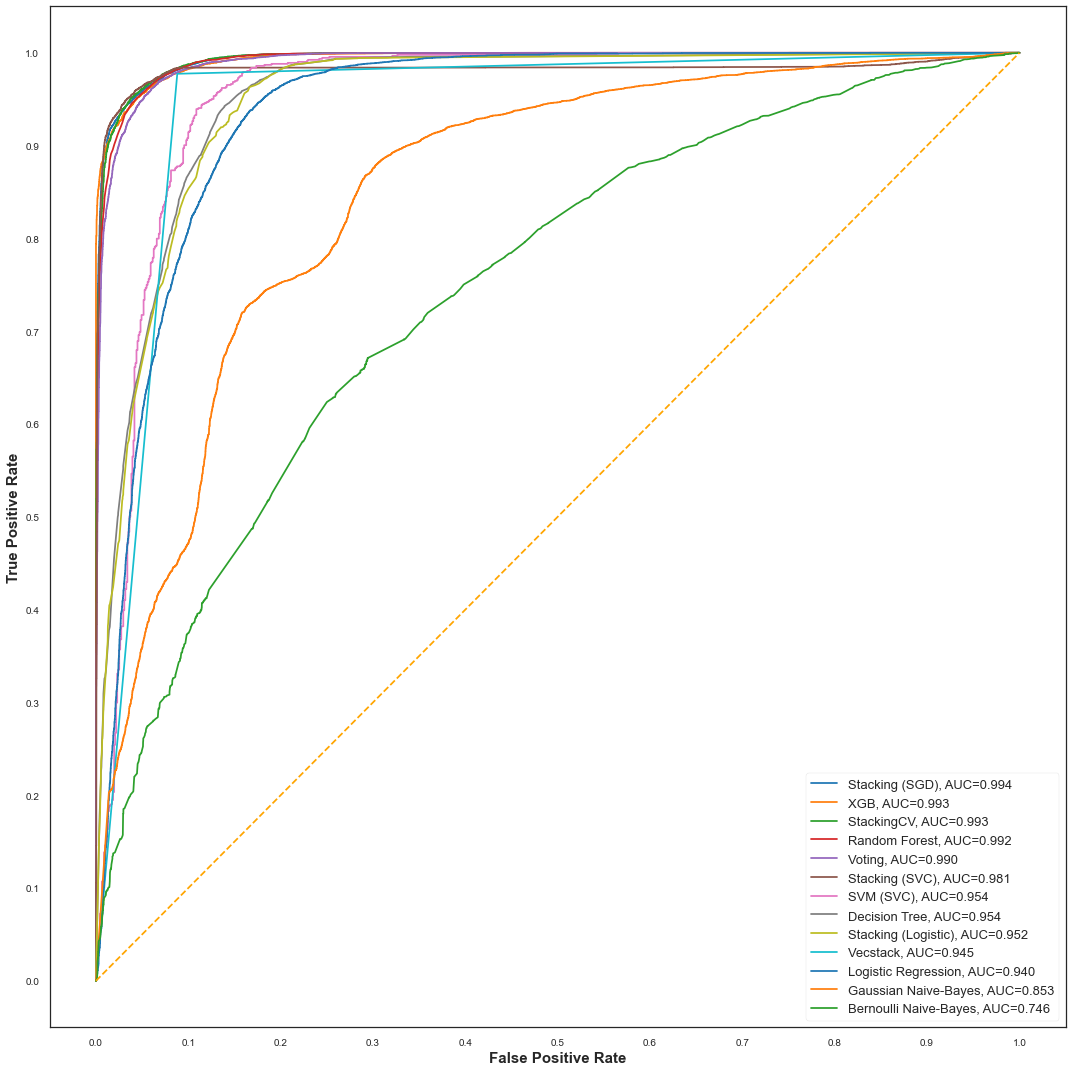

In [152]:
fig = plt.figure(figsize=(15,15))

for i in roc_plot_df.index:
    plt.plot(roc_plot_df.loc[i]['FPR'], 
             roc_plot_df.loc[i]['TPR'], 
             label="{}, AUC={:.3f}".format(i, roc_plot_df.loc[i]['AUC']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')
plt.rcParams.update({'figure.autolayout': True})

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15, fontweight="bold")

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15, fontweight="bold")

#plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.savefig('ROC_Curve_Analysis.png')

plt.show()

In [142]:
results_df_temp.reset_index(inplace=True)
df_results_temp_scatter = results_df_temp[(results_df_temp['Recall']>0.85) & (results_df_temp['Precision']>0.85)]
df_results_temp_scatter = df_results_temp_scatter.loc[:, ['Classifier','Precision', 'Recall']].sort_values(by='Precision')

In [143]:
df_results_temp_scatter

,Classifier,Precision,Recall
3,Logistic Regression,0.864974,0.896469
6,Stacking (Logistic),0.866722,0.924326
1,Decision Tree,0.867579,0.945602
5,SVM (SVC),0.888325,0.946970
10,Vecstack,0.916967,0.977407
11,Voting,0.926707,0.973459
4,Random Forest,0.929984,0.974556
9,StackingCV,0.948244,0.962492
12,XGB,0.950748,0.954815
7,Stacking (SGD),0.950888,0.957666


In [153]:
precision = df_results_temp_scatter['Precision'].to_list
recall = df_results_temp_scatter['Recall'].to_list
classifier = df_results_temp_scatter['Classifier'].to_list

<Figure size 576x396 with 0 Axes>

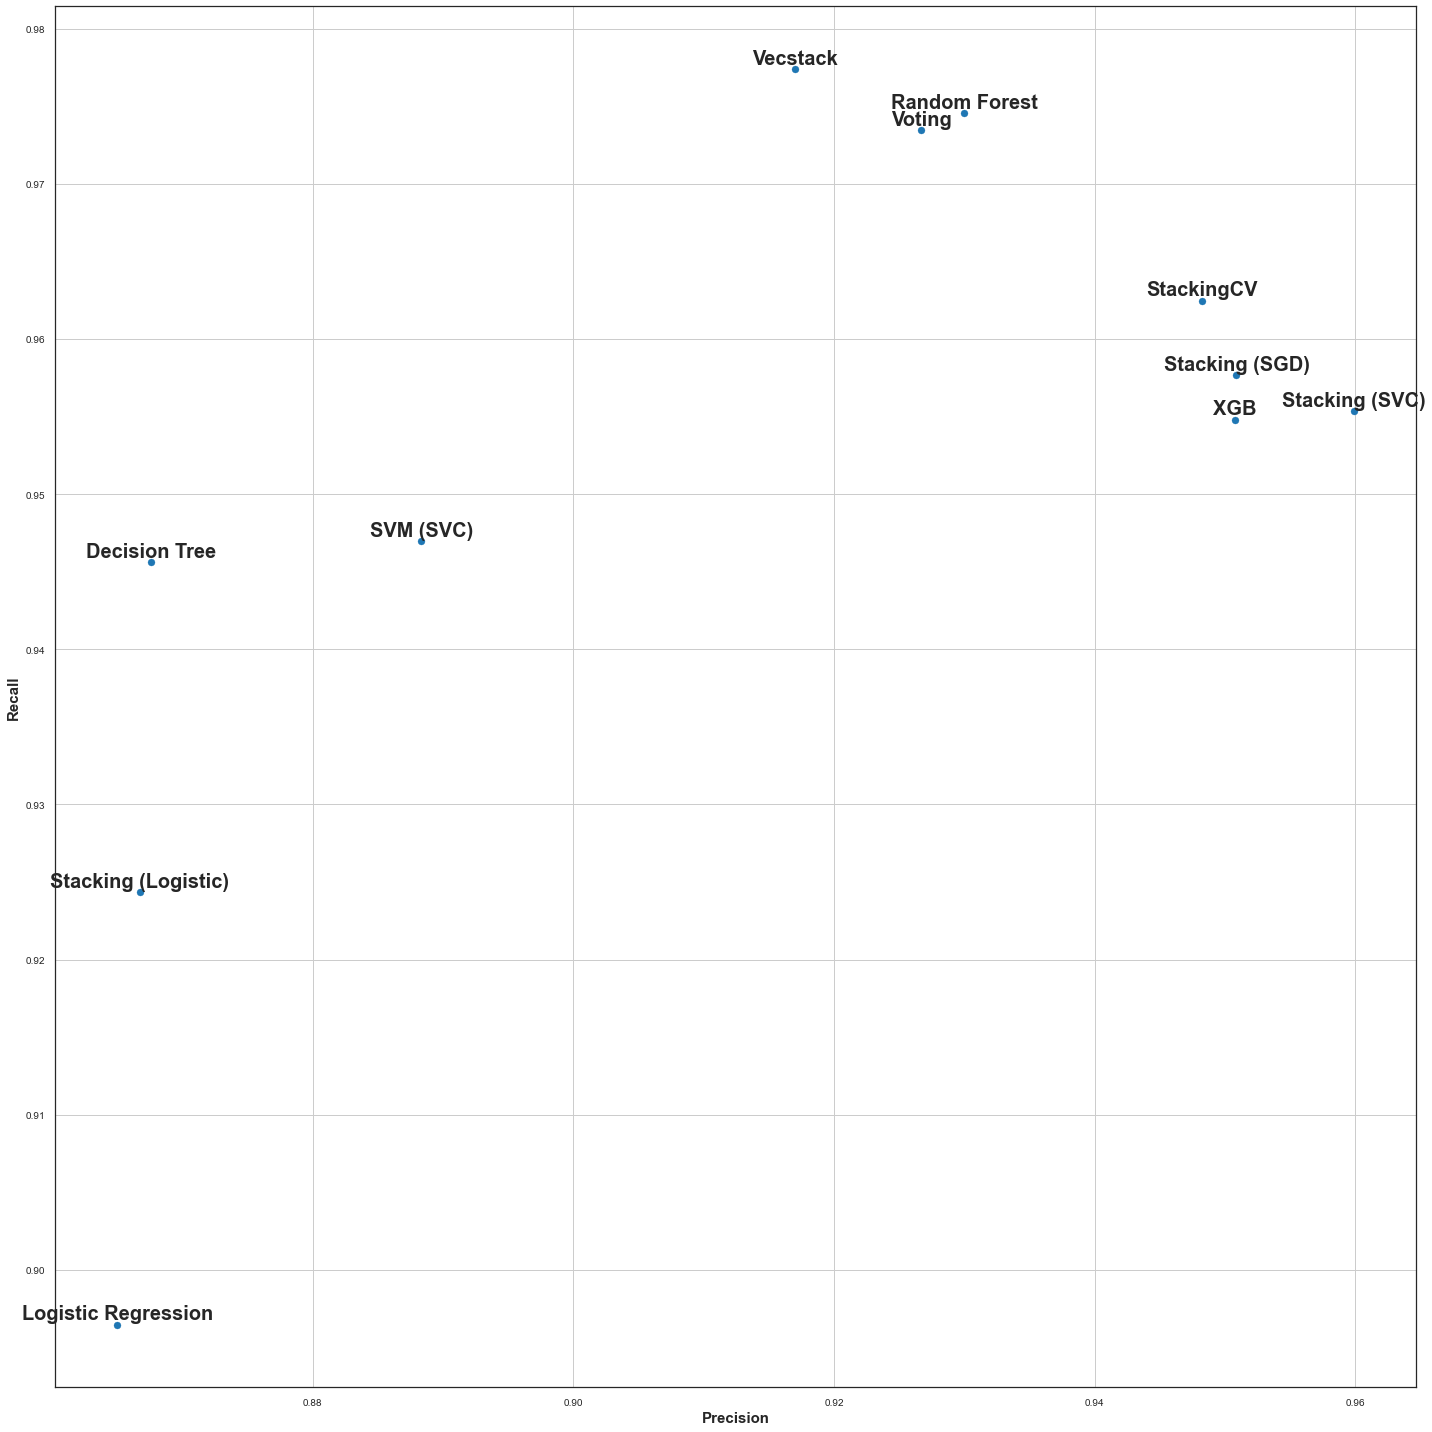

In [151]:
plt.clf()
plt.rcParams.update({'figure.autolayout': True})
plt.figure(figsize=(20,20))
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.scatter(df_results_temp_scatter.Precision, df_results_temp_scatter.Recall)
plt.grid()
for x,y,z in zip(df_results_temp_scatter.Precision, df_results_temp_scatter.Recall, df_results_temp_scatter.Classifier):

    plt.annotate(z, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 fontweight="bold", 
                 fontsize = 20, 
                 ha='center') # horizontal alignment can be left, right or center

#plt.title("Precision vs. Recall", fontsize = 15, fontweight="bold")
plt.xlabel("Precision", fontsize=15, fontweight="bold")
plt.ylabel("Recall", fontsize=15, fontweight="bold")
plt.savefig('Precision_vs_Recall.png')
plt.show()

In [146]:
results_df_final = results_df_temp.iloc[:, [0,1,3,2,4,5,8,9,10,11,12,13]].sort_values(by='AUC', ascending=False)

In [147]:
results_df_temp

,Classifier,Features,Accuracy,Parameters,Recall,Precision,FPR,TPR,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives,Cost
0,Bernoulli Naive-Bayes,Full,0.685947,Default,0.664510,0.693329,"[0.0, 0.00010921799912625601, 0.00021843599825...","[0.0, 0.0, 0.0, 0.0005483658697082694, 0.00065...",0.746340,6059,6476,2680,3059,1556300
1,Decision Tree,Reduced,0.900843,Best,0.945602,0.867579,"[0.0, 0.00327653997378768, 0.00360419397116644...","[0.0, 0.14948453608247422, 0.16790962930467207...",0.953783,8622,7840,1316,496,261160
2,Gaussian Naive-Bayes,Full,0.770822,Default,0.759596,0.776283,"[0.0, 0.013979903888160769, 0.0140891218872870...","[0.0, 0.20311471813994297, 0.20322439131388462...",0.852750,6926,7160,1996,2192,1115960
3,Logistic Regression,Full,0.878516,Default,0.896469,0.864974,"[0.0, 0.0, 0.00021843599825251202, 0.000218435...","[0.0, 0.00010967317394165388, 0.00010967317394...",0.940097,8174,7880,1276,944,484760
4,Random Forest,Reduced,0.950695,Default,0.974556,0.929984,"[0.0, 0.00010921799912625601, 0.00032765399737...","[0.0, 0.2025663522702347, 0.33494187321781094,...",0.992112,8886,8487,669,232,122690
5,SVM (SVC),Full,0.913304,Default,0.946970,0.888325,"[0.0, 0.0, 0.0, 0.001098901098901099, 0.001098...","[0.0, 0.0010822510822510823, 0.009740259740259...",0.953984,875,800,110,49,25600
6,Stacking (Logistic),Reduced,0.891321,Best,0.924326,0.866722,"[0.0, 0.00327653997378768, 0.00338575797291393...","[0.0, 0.14948453608247422, 0.1522263654310156,...",0.951552,8428,7860,1296,690,357960
7,Stacking (SGD),Reduced,0.954197,Best,0.957666,0.950888,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00471594647949...",0.993582,8732,8705,451,386,197510
8,Stacking (SVC),Reduced,0.957809,Best,0.955363,0.959890,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00767712217591...",0.981384,8711,8792,364,407,207140
9,StackingCV,Reduced,0.955073,Best,0.962492,0.948244,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00010967317394165388, 0.00438692695766...",0.993224,8776,8677,479,342,175790


In [154]:
results_df_final

,Classifier,Features,Parameters,Accuracy,Recall,Precision,AUC,True_Positives,True_Negatives,False_Positives,False_Negatives,Cost
7,Stacking (SGD),Reduced,Best,0.954197,0.957666,0.950888,0.993582,8732,8705,451,386,197510
12,XGB,Reduced,Default,0.952774,0.954815,0.950748,0.993451,8706,8705,451,412,210510
9,StackingCV,Reduced,Best,0.955073,0.962492,0.948244,0.993224,8776,8677,479,342,175790
4,Random Forest,Reduced,Default,0.950695,0.974556,0.929984,0.992112,8886,8487,669,232,122690
11,Voting,Reduced,Best,0.948342,0.973459,0.926707,0.990425,8876,8454,702,242,128020
8,Stacking (SVC),Reduced,Best,0.957809,0.955363,0.959890,0.981384,8711,8792,364,407,207140
5,SVM (SVC),Full,Default,0.913304,0.946970,0.888325,0.953984,875,800,110,49,25600
1,Decision Tree,Reduced,Best,0.900843,0.945602,0.867579,0.953783,8622,7840,1316,496,261160
6,Stacking (Logistic),Reduced,Best,0.891321,0.924326,0.866722,0.951552,8428,7860,1296,690,357960
10,Vecstack,Reduced,Best,0.944566,0.977407,0.916967,0.944634,8912,8349,807,206,111070


In [149]:
results_df_final.to_excel("results_final_20_input.xlsx", sheet_name='Sheet_name_1')